<a href="https://colab.research.google.com/github/DCEG-workshops/statgen_workshop_tutorial/blob/main/src/02_GWAS%26MetaAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this exercise, we will be using [plink](www.cog-genomics.org/plink/1.9/) to perform Genome Wide Association Studies using the publicly available PennCath data.  First, we will evaluate the data with a continous outcome using **linear regression** and covariates estimated from the --pca step in last lecture. Then, we will evaluate our results using **Quantile-Quantile Plots** (QQplots), **Manhattan plots**, and **Regional plots** for follow-up.  We will also perform another GWAS using the binary trait Coronary Artery Disease (CAD) and **logistic regression** which is often what we use when evaluating germline genetic susceptibility to cancer.

# Setup
Before we get started, make sure you have the statgen_workshop folder added to your drive.  See the link and screenshot below if you need help with this step.

***Important***: We want to mount the *google drive* for the data neeed for this workshop. Please open this [link](https://drive.google.com/drive/folders/1rui3w4tok2Z7EhtMbz6PobeC_fDxTw7G?usp=sharing) with your Google drive and find the "statgen_workshop" folder under "Share with me". Then add a shortcut to the folder under "My Drive", as shown in the screenshot.  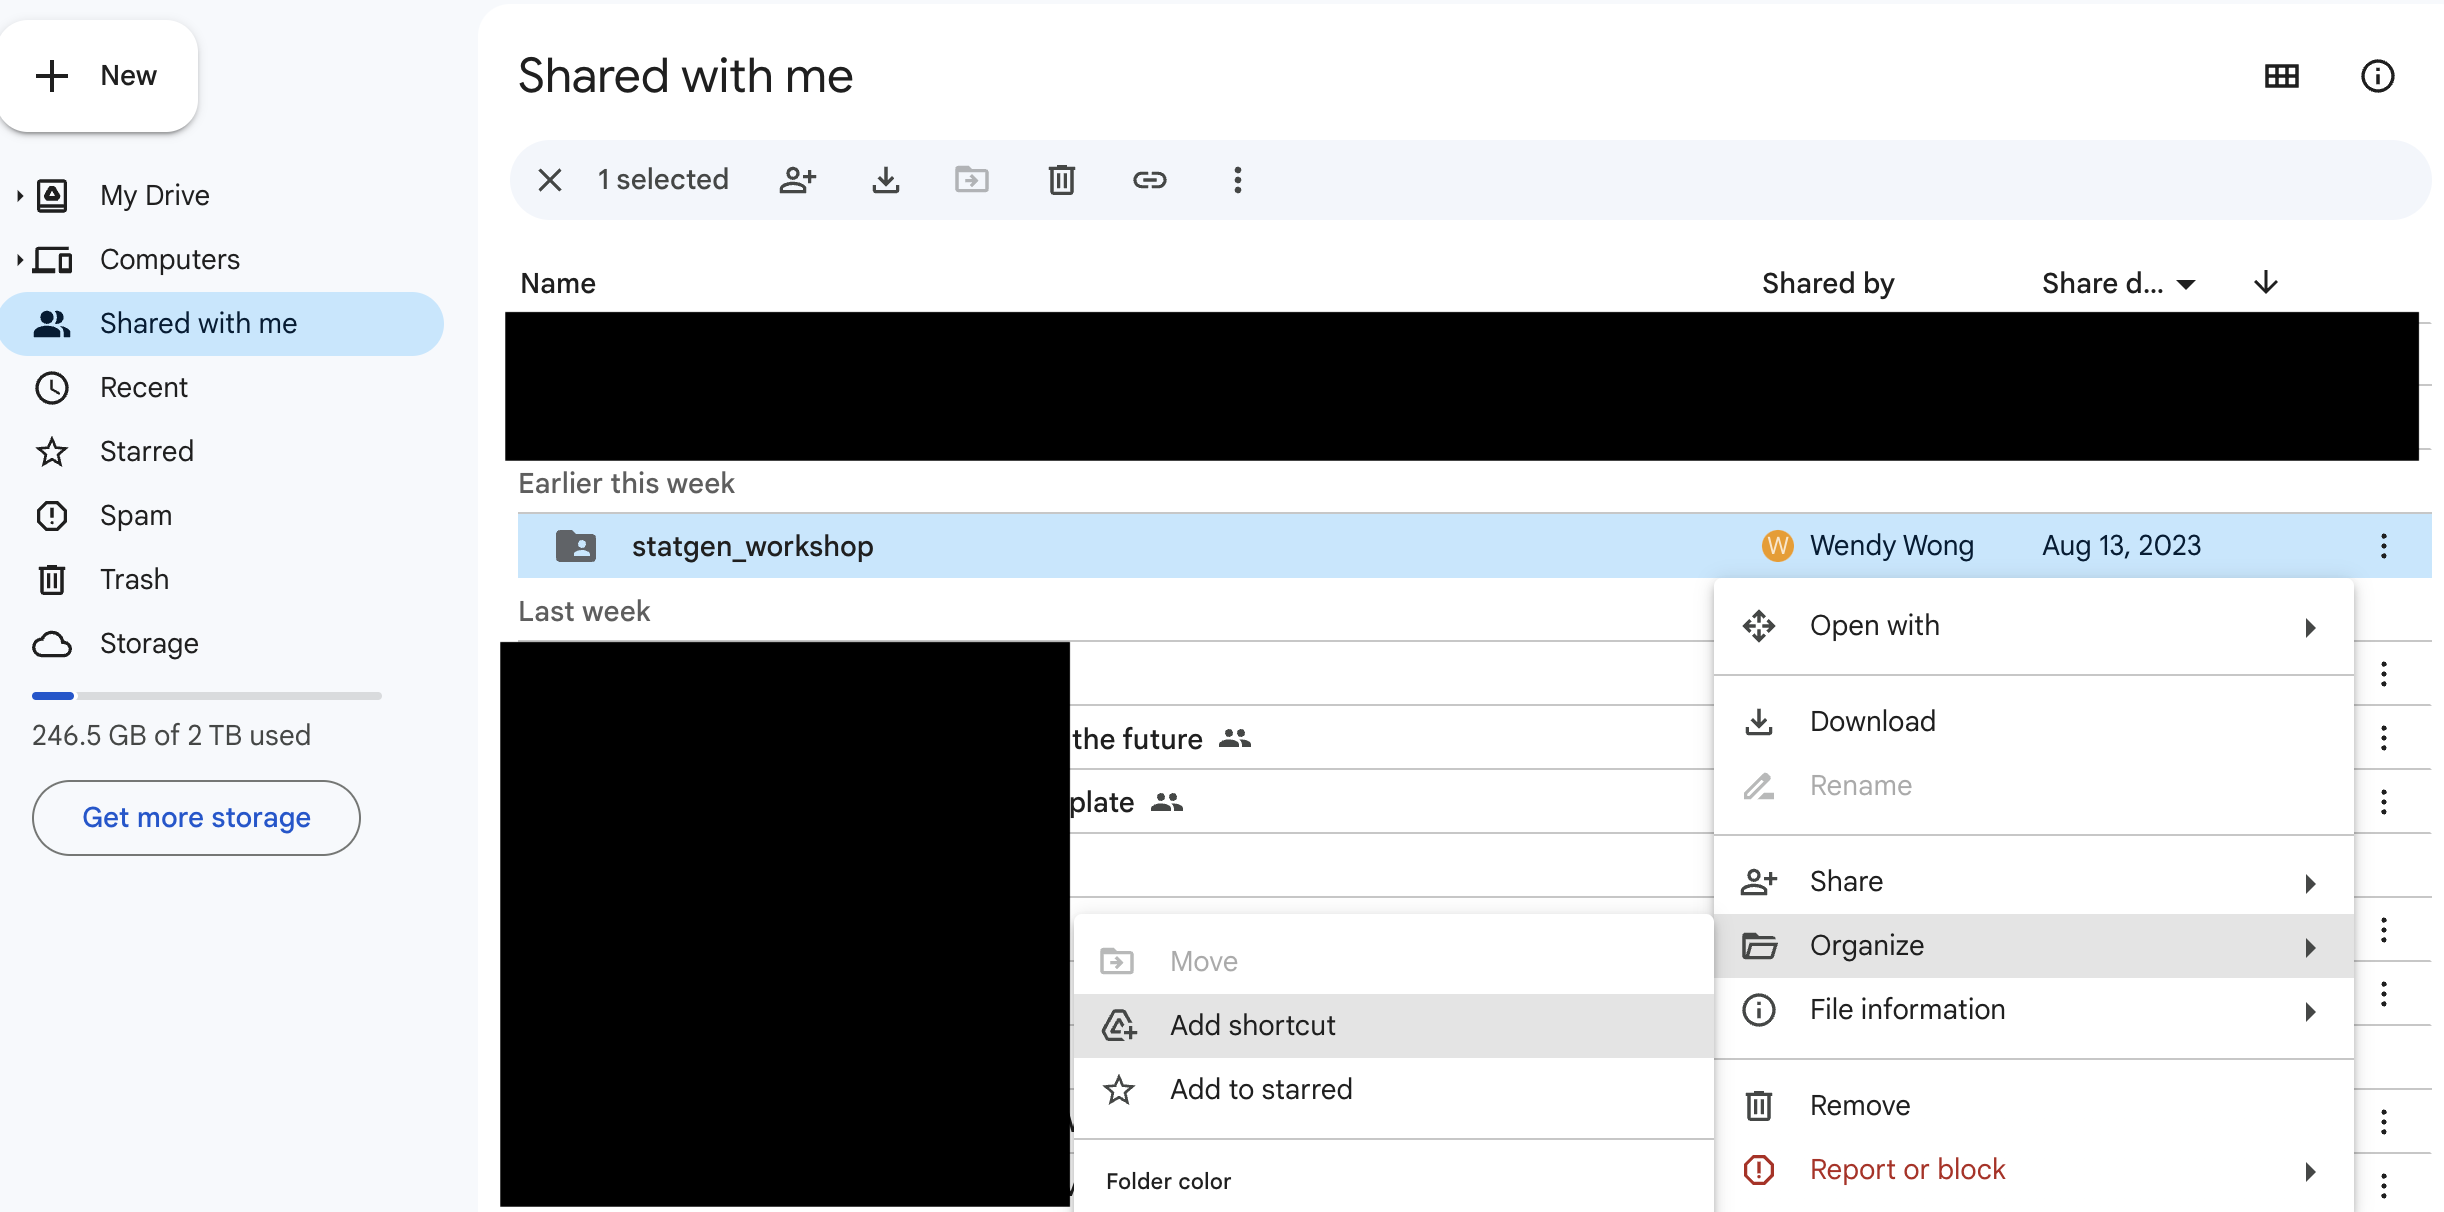

When you import the drive, your google will popup a security alert. Be sure to grant yourself access.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Now we can look at the contents of the drive using the list (ls) command and verify the drive is added to "MyDrive"

In [ ]:
!ls /content/drive/MyDrive/statgen_workshop

containers  data  notebooks  outputs  tools


We will set path variables to simplify our coding to not require the full drive path for the input and output datasets. I will show some examples with the full path so you can see both.


In [ ]:
import os
input_dir="drive/MyDrive/statgen_workshop/data/workshop2/"
tools_dir="drive/MyDrive/statgen_workshop/tools"
analysis_dir=os.getcwd() + "/02_analysis/"
os.environ['input_dir']=input_dir
os.environ['analysis_dir']=analysis_dir
os.environ['tools_dir']=tools_dir

We will create the local analysis directory

In [ ]:
%%bash
mkdir -p ${analysis_dir}

load R magic, so that we can run R here and share variables

In [ ]:
%load_ext rpy2.ipython

Load R libraries and set shared variables

In [ ]:
%%R -i input_dir -i analysis_dir
library(glue)

Download plink if it has not been installed.

In [ ]:
%%bash
if [ ! -f /tools/node/bin/plink ]; then
   curl -o /tools/node/bin/plink.zip https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20230116.zip && \
   cd /tools/node/bin/ && \
   unzip plink.zip
fi

Archive:  plink.zip
  inflating: plink                   
  inflating: LICENSE                 
  inflating: toy.ped                 
  inflating: toy.map                 
  inflating: prettify                


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8743k  100 8743k    0     0  9273k      0 --:--:-- --:--:-- --:--:-- 9272k


Take a look at the input files.  Note: These will be different than session #1 as we are in a different folder for session #2. Be sure these files are listed so you confirm your directory and path variables are set correctly.

In [ ]:
%%bash
ls ${input_dir}


bcac2.txt
bcac.txt
cad_result_maf0.05.logistic.clean.txt
covar.txt
HanEskinPvalueTable.txt
penncath_clean_maf0.001.bed
penncath_clean_maf0.001.bim
penncath_clean_maf0.001.fam
penncath_clean_maf0.001.log
penncath_clean_maf0.05.bed
penncath_clean_maf0.05.bim
penncath_clean_maf0.05.fam
penncath_clean_maf0.05.log
penncath_extradata.txt
qt_result_maf0.05.linear.clean.txt
sim_pheno.pheno


Now that we are setup, we will take a look at some of our data inputs.

# Covariates
The covar.txt file includes the variables we want as covariates for our GWAS. This file is in plink's standard covariate file input structure with the FID, IID and then covariates listed.  An unadjusted GWAS would be confounded by population stratification.  Here, our covariate file includes the output from the --pca command we ran last time on the pruned data inputs.  I have included the first 10 PCs as our covariates for this practical. **Caution**: Do not estimate PCs using unpruned genetic markers! Note: Matching by PCs, only controlling for PCs associated with the outcome, including less PCs, etc. are all things that may be preferred to this simplified example.

In [ ]:
%%bash
head ${input_dir}/covar.txt

FID IID PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10
"10002" 1 0.0107508 -0.0186999 0.00225634 -0.0173534 0.0028573 0.00535477 0.0165129 0.00266538 -0.00657658 0.0197859
"10004" 1 -0.0123042 -0.00250051 -0.00390513 0.0301879 -0.0151968 0.0261312 -0.0137882 0.0354597 0.0498757 0.00528846
"10005" 1 -0.0168912 0.00222565 0.020879 0.0245645 -0.0300538 0.0114122 0.0183635 -0.0261686 0.00144292 0.00494541
"10007" 1 -0.0109065 -0.00387851 0.0154937 -0.000899995 0.0025128 0.0418788 -0.025301 -0.0180804 -0.00201208 -0.0275519
"10008" 1 -0.0150977 -3.60578e-05 0.0160107 -0.00243951 0.00569742 0.012319 -0.00890553 -0.0128686 0.0118808 0.017205
"10009" 1 -0.0119338 0.00156613 0.0141867 0.0229229 -0.0118446 0.0166977 0.0123441 -0.0334156 -0.0135842 0.0103975
"10010" 1 -0.0127906 -0.00901022 0.0158329 0.00904012 -0.0190074 -0.0137995 0.0170831 0.00268959 0.00695677 0.00254176
"10011" 1 -0.0136141 -0.00347786 0.0145856 0.0367844 -0.0113628 0.0193315 -0.019366 0.00692124 0.0138617 0.0185989
"10012" 1 -0.0

# Phenotype (Outcome) Variable
The sim_pheno.pheno phenotype file includes our continuous phenotype for each participant.  This file is also structured for plink with the standard plink phenotype file input columns. The ".fam" file in plink can also contain the phenotype.  A ".fam" file 6th column is for phenotype.  The phenotype can be set to missing "-9" or may contain a phenotype of interest.  Here, our phenotype column contains a binary variable for CAD.  

In [ ]:
%%bash
head ${input_dir}/sim_pheno.pheno

"10002" 1 -2.12669 
"10004" 1 1.3236 
"10005" 1 -0.0529849 
"10007" 1 -3.99226 
"10008" 1 -1.65679 
"10009" 1 0.0375889 
"10010" 1 0.931166 
"10011" 1 0.72109 
"10012" 1 -0.57625 
"10013" 1 -0.400321 


In [ ]:
%%bash
head ${input_dir}/penncath_clean_maf0.05.fam

"10002" 1 0 0 1 1
"10004" 1 0 0 2 1
"10005" 1 0 0 1 2
"10007" 1 0 0 1 1
"10008" 1 0 0 1 2
"10009" 1 0 0 1 2
"10010" 1 0 0 1 2
"10011" 1 0 0 2 1
"10012" 1 0 0 1 2
"10013" 1 0 0 2 -9


# **GWAS 1: Linear Regression**
Starting with our quantitative phenotype, we will run linear regression for the relationship between each variant and our quantitative trait adjusted for our covariates. **But wait!** First we must check assumptions of a linear regression model.  If our outcome variable does not follow a normal distribution, we may need to log-transform it.  

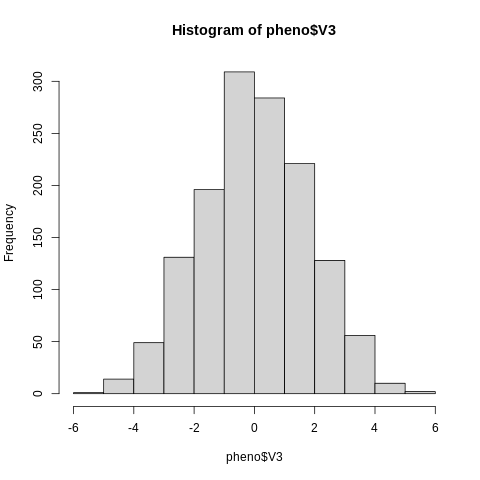

In [ ]:
%%R
pheno<-read.table(glue(input_dir, "sim_pheno.pheno"), as.is=T, header=F)
hist(pheno$V3)


# Linear Regression in Plink
We will now test the association between each genetic variant and a quantitative variable.  
Here we have also specified a few additional options.  We used "--ci 0.95" to request the se, upper and lower 95% confidence intervals.  This is linear regression as indicated by the "--linear" command.  For other plink options see the plink documentation [here](https://www.cog-genomics.org/plink/1.9/).

In [ ]:
%%bash
plink --threads 2 \
      --bfile ${input_dir}/penncath_clean_maf0.05 \
      --allow-no-sex --covar ${input_dir}/covar.txt \
      --pheno ${input_dir}/sim_pheno.pheno \
      --linear \
      --ci 0.95 \
      --out ${analysis_dir}/linear_result

# Results of the linear regression model
Let's take a brief look at our results.  What do you notice?  Are these results ready to plot?

In [ ]:
%%bash
head ${analysis_dir}/linear_result.assoc.linear

 CHR          SNP         BP   A1       TEST    NMISS       BETA       SE      L95      U95         STAT            P 
   1   rs12565286     721290    G        ADD     1365  -0.009298   0.1549  -0.3129   0.2943     -0.06004       0.9521
   1   rs12565286     721290    G        PC1     1365      4.478    1.816    0.919    8.037        2.466      0.01378
   1   rs12565286     721290    G        PC2     1365     -2.663    1.804   -6.198   0.8725       -1.476       0.1401
   1   rs12565286     721290    G        PC3     1365     0.8356    1.793   -2.679     4.35        0.466       0.6413
   1   rs12565286     721290    G        PC4     1365     0.1801    1.797   -3.343    3.703       0.1002       0.9202
   1   rs12565286     721290    G        PC5     1365     -1.925    1.792   -5.437    1.586       -1.075       0.2828
   1   rs12565286     721290    G        PC6     1365      1.276    1.814   -2.279    4.832       0.7035       0.4818
   1   rs12565286     721290    G        PC7     1365  

We only want to plot the results of the additive model, not the PC covariates.  We can remove these using many different programs.  Below I removed them quickly and made a clean file named "qt_result_maf0.05.linear.clean.txt"

In [ ]:
%%bash
 awk '$5 == "ADD" && $12 != "NA"' ${analysis_dir}/linear_result.assoc.linear > ${analysis_dir}/qt_result_maf0.05.linear.clean.txt

In [ ]:
%%bash
ls ${analysis_dir}

linear_result.assoc.linear
linear_result.log
qt_result_maf0.05.linear.clean.txt


You can see snp results with PCs are no longer in the file with a quick print of the head of the file.

In [ ]:
%%bash
head ${analysis_dir}/qt_result_maf0.05.linear.clean.txt

   1   rs12565286     721290    G        ADD     1365  -0.009298   0.1549  -0.3129   0.2943     -0.06004       0.9521
   1    rs3094315     752566    C        ADD     1366   -0.09424  0.08607  -0.2629  0.07446       -1.095       0.2738
   1    rs2286139     761732    C        ADD     1344    -0.1345   0.1001  -0.3307  0.06163       -1.344       0.1791
   1    rs2980319     777122    A        ADD     1380    -0.1536  0.09977  -0.3491  0.04197       -1.539        0.124
   1    rs2980300     785989    A        ADD     1363    -0.1414  0.09756  -0.3326  0.04983       -1.449       0.1475
   1   rs11240777     798959    A        ADD     1380    -0.1794  0.08245   -0.341 -0.01779       -2.176      0.02975
   1    rs3748597     888659    T        ADD     1378    -0.3323   0.1558  -0.6377 -0.02692       -2.133      0.03313
   1    rs2341354     918573    A        ADD     1303    0.09309  0.07294 -0.04988   0.2361        1.276       0.2021
   1       rs1921     949608    A        ADD     1317   

Then we can read our file into R to do some plotting!

In [ ]:
%%R
qt_result_maf05 <- read.table("drive/MyDrive/statgen_workshop/data/workshop2/qt_result_maf0.05.linear.clean.txt", header=F, as.is=T)
colnames(qt_result_maf05)<-c("CHR", "SNP", "BP", "A1", "TEST", "NMISS", "OR", "SE", "L95", "U95", "STAT", "P")
head(qt_result_maf05)

  CHR        SNP     BP A1 TEST NMISS        OR      SE     L95      U95
1   1 rs12565286 721290  G  ADD  1365 -0.009298 0.15490 -0.3129  0.29430
2   1  rs3094315 752566  C  ADD  1366 -0.094240 0.08607 -0.2629  0.07446
3   1  rs2286139 761732  C  ADD  1344 -0.134500 0.10010 -0.3307  0.06163
4   1  rs2980319 777122  A  ADD  1380 -0.153600 0.09977 -0.3491  0.04197
5   1  rs2980300 785989  A  ADD  1363 -0.141400 0.09756 -0.3326  0.04983
6   1 rs11240777 798959  A  ADD  1380 -0.179400 0.08245 -0.3410 -0.01779
      STAT       P
1 -0.06004 0.95210
2 -1.09500 0.27380
3 -1.34400 0.17910
4 -1.53900 0.12400
5 -1.44900 0.14750
6 -2.17600 0.02975


# QQPlots
We will use an R package called QQman to visually assess our results. This package is very easy to use and has a vignette you can run with vignette('qqman') to see more options.  First we will start with a QQplot.  **Questions:**  Based on this QQplot, do we have inflation?  What do you expect the lambda to be?  Do we expect to see towers in our manhattan plot? Stars?

(as ‘lib’ is unspecified)














	‘/tmp/RtmpFjkWkW/downloaded_packages’









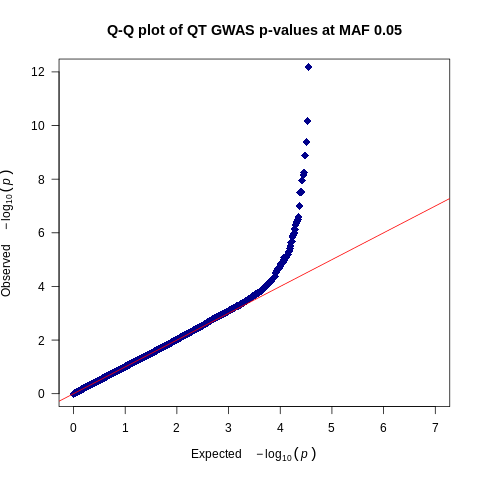

In [ ]:
%%R
install.packages("qqman")
library(qqman)
qq(qt_result_maf05$P, main = "Q-Q plot of QT GWAS p-values at MAF 0.05", xlim = c(0, 7), ylim = c(0,
    12), pch = 18, col = "blue4", cex = 1.5, las = 1)


We can also calculate the lambda value.  Given the QQplot above, what do you expect the lambda value to be?

In [ ]:
%%R
chisq <- qchisq(qt_result_maf05$P, 1, lower.tail = F)
lambda <- median(chisq) / qchisq(0.5,1)
print(lambda)

[1] 1.015011


# Manhattan Plots
We will use the same R package called QQman. What do you see in the plot below? Do we have genomic loci of interest? Is there a chromosome or region we should look at closer?

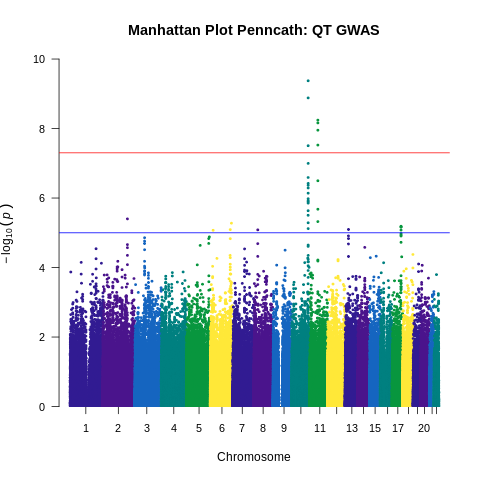

In [ ]:
%%R
#library(qqman)
manhattan(qt_result_maf05, main = "Manhattan Plot Penncath: QT GWAS", ylim = c(0, 10), cex = 0.6, cex.axis = 0.9,
    col = c("#311B92", "#4A148C", "#1565C0", "#008080", "#08963E", "#FFE838"), chrlabs = c(1:22,
        "P", "Q"))


# Regional Plots
Let's now look closer at a specific region region using the qqman package.


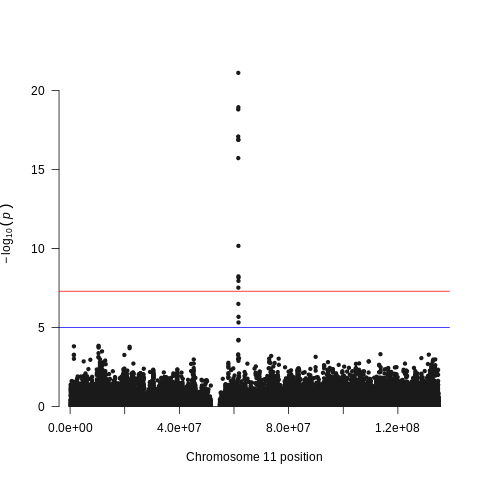

In [ ]:
%%R
manhattan(subset(qt_result_maf05, CHR == 11))

We can even zoom in to positions or annotate our snps for closer inspection.

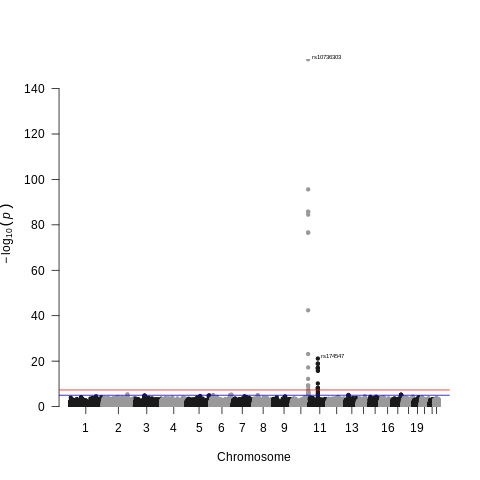

In [ ]:
%%R
manhattan(qt_result_maf05, annotatePval = 0.000000005)

Let's sort the output file s

In [ ]:
%%bash
small_p<-qt_result_maf05[-order(qt_result_maf05$P),]

# Annotation Tools/Software
Now let's pause from the Notebook and look at our results using some internet tools available for initial annotation of genes/snps.  Keep in mind this is just the start!  The next lectures will consist of more details to help you identify the causal snp!

# **GWAS 2: Logistic Regression**
Now let's run a logistic regression model using our binary variable. This is often what we work with when looking at cancer outcomes!

In [ ]:
%%bash
plink  --threads 2 \
       --bfile ${input_dir}/penncath_clean_maf0.05  \
       --allow-no-sex --covar ${input_dir}/covar.txt \
       --logistic --ci 0.95 \
       --out ${analysis_dir}/cad_result_maf0.05

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/02_analysis//cad_result_maf0.05.log.
Options in effect:
  --allow-no-sex
  --bfile drive/MyDrive/statgen_workshop/data/workshop2//penncath_clean_maf0.05
  --ci 0.95
  --covar drive/MyDrive/statgen_workshop/data/workshop2//covar.txt
  --logistic
  --out /content/02_analysis//cad_result_maf0.05
  --threads 2

12982 MB RAM detected; reserving 6491 MB for main workspace.
626430 variants loaded from .bim file.
1401 people (937 males, 464 females) loaded from .fam.
933 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
--covar: 10 covariates loaded.
21 people were not seen in the covariate file.
Before main variant filters, 1401 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%

In [ ]:
%%bash
ls -lrt ${analysis_dir}

total 866264
-rw-r--r-- 1 root root 813116762 Sep 19 23:53 linear_result.assoc.linear
-rw-r--r-- 1 root root      1196 Sep 19 23:53 linear_result.log
-rw-r--r-- 1 root root  73928367 Sep 20 00:01 qt_result_maf0.05.linear.clean.txt


# Viewing Our Results
Now let's take these results to QQplots and Manhattan Plots. We only want to plot the results of the additive model, not the PC covariates. We can remove these using python, R, or linux. To save time, I have placed a clean results file in the inputs directory under "cad_result_maf0.05.logistic_clean.txt"



In [ ]:
%%bash
head ${input_dir}/cad_result_maf0.05.logistic.clean.txt

CHR SNP BP A1 TEST NMISS OR SE L95 U95 STAT P
1 rs12565286 721290 G ADD 908 0.9087 0.2109 0.601 1.374 -0.4537 0.65
1 rs3094315 752566 C ADD 905 0.9508 0.1197 0.752 1.202 -0.4212 0.6736
1 rs2286139 761732 C ADD 893 0.9874 0.1436 0.7452 1.308 -0.0885 0.9295
1 rs2980319 777122 A ADD 918 1.004 0.142 0.7598 1.325 0.02512 0.98
1 rs2980300 785989 A ADD 908 0.974 0.137 0.7447 1.274 -0.1924 0.8474
1 rs11240777 798959 A ADD 918 0.9693 0.1138 0.7755 1.211 -0.2742 0.784
1 rs3748597 888659 T ADD 917 1.029 0.2194 0.6695 1.582 0.1317 0.8952
1 rs2341354 918573 A ADD 872 1.17 0.1033 0.9554 1.432 1.518 0.1289
1 rs1921 949608 A ADD 872 1.223 0.1044 0.9969 1.501 1.93 0.05364


In [ ]:
%%R
cad_result_maf05 <- read.table(glue(input_dir, "cad_result_maf0.05.logistic.clean.txt"), header=T, as.is=T)
head(cad_result_maf05)

  CHR        SNP     BP A1 TEST NMISS     OR     SE    L95   U95     STAT
1   1 rs12565286 721290  G  ADD   908 0.9087 0.2109 0.6010 1.374 -0.45370
2   1  rs3094315 752566  C  ADD   905 0.9508 0.1197 0.7520 1.202 -0.42120
3   1  rs2286139 761732  C  ADD   893 0.9874 0.1436 0.7452 1.308 -0.08850
4   1  rs2980319 777122  A  ADD   918 1.0040 0.1420 0.7598 1.325  0.02512
5   1  rs2980300 785989  A  ADD   908 0.9740 0.1370 0.7447 1.274 -0.19240
6   1 rs11240777 798959  A  ADD   918 0.9693 0.1138 0.7755 1.211 -0.27420
       P
1 0.6500
2 0.6736
3 0.9295
4 0.9800
5 0.8474
6 0.7840


# QQPlots
From these results do you think we found genomic loci associated with CAD?  

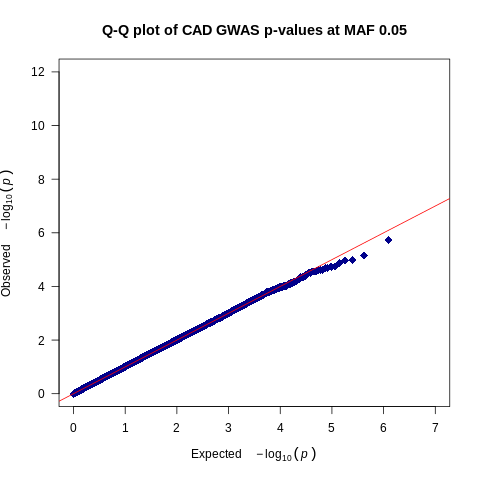

In [ ]:
%%R
#install.packages("qqman")
library(qqman)
qq(cad_result_maf05$P, main = "Q-Q plot of CAD GWAS p-values at MAF 0.05", xlim = c(0, 7), ylim = c(0,
    12), pch = 18, col = "blue4", cex = 1.5, las = 1)


Based on this QQplot, what do you expect our lambda value to be?

In [ ]:
%%R
chisq <- qchisq(cad_result_maf05$P, 1, lower.tail = F)
lambda <- median(chisq) / qchisq(0.5,1)
print(lambda)

[1] 1.008424


# Manhattan Plots
Once again using qqman, we can plot our association across the genome with CAD.

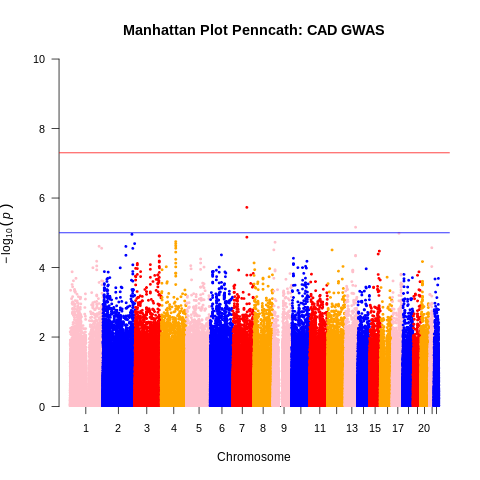

In [ ]:
%%R
#library(qqman)
manhattan(cad_result_maf05, main = "Manhattan Plot Penncath: CAD GWAS", ylim = c(0, 10), cex = 0.6, cex.axis = 0.9,
    col = c("pink", "blue", "red", "orange"), chrlabs = c(1:22,
        "P", "Q"))


Some studies choose to look closer at hits that do not reach genome wide significance (red line).  We can annotate nominal p-values with code like that below.

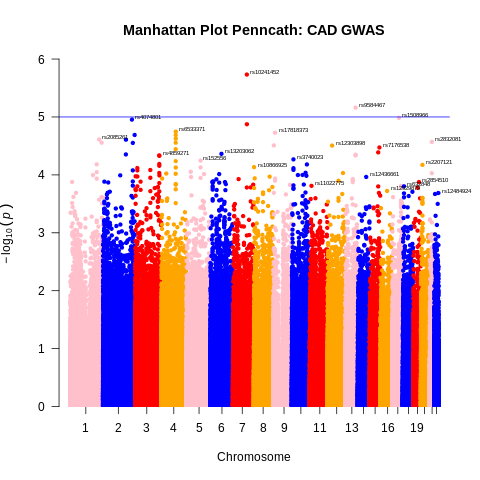

In [ ]:
%%R
manhattan(cad_result_maf05, annotatePval = 0.05, main = "Manhattan Plot Penncath: CAD GWAS",
    col = c("pink", "blue", "red", "orange"), chrlabs = c(1:22, "P", "Q"))


# **Challenge 1**

The dataset below includes additional variables you can use to practice your GWAS skills. The dataset includes the FID that all phenotype and covariate files start with.  Choose a new phenotype.  Consider is that phenotype binary or continuous? Should additional variables like age (also within the file) be used as covariates?  Does the variable have missingness or need to be transformed? Use the file to make new input files and then write a plink script to run a new GWAS.  



In [ ]:
%%bash
head ${input_dir}/penncath_extradata.txt

FID CAD sex age tg hdl ldl loghdl
"10002" 1 1 60 NA NA NA NA
"10004" 1 2 50 55 23 75 3.13549421592915
"10005" 1 1 55 105 37 69 3.61091791264422
"10007" 1 1 52 314 54 108 3.98898404656427
"10008" 1 1 58 161 40 94 3.68887945411394
"10009" 1 1 59 171 46 92 3.8286413964891
"10010" 1 1 54 147 69 109 4.23410650459726
"10011" 1 2 66 124 47 84 3.85014760171006
"10012" 1 1 58 60 114 67 4.7361984483945


In [ ]:
#code block for Challenge 1

# **Challenge 2**
GWAS are deployed for common variants.  The minor allele frequency cutoff for most GWAS used to be 0.05 (5%), but now many GWAS go lower.  Rare variants can be a source of inflation.  Perform a GWAS from above with a rarer variant input file (See the ls command below displaying available plink bed/bim/fam input files with maf 0.001).  Evaluate the qqplot.  Does incorporating lower maf variants cause inflation in your GWAS? Did your lambda value change?

In [ ]:
%%bash
ls ${input_dir}

bcac2.txt
bcac.txt
cad_result_maf0.05.logistic.clean.txt
covar.txt
HanEskinPvalueTable.txt
penncath_clean_maf0.001.bed
penncath_clean_maf0.001.bim
penncath_clean_maf0.001.fam
penncath_clean_maf0.001.log
penncath_clean_maf0.05.bed
penncath_clean_maf0.05.bim
penncath_clean_maf0.05.fam
penncath_clean_maf0.05.log
penncath_extradata.txt
qt_result_maf0.05.linear.clean.txt
sim_pheno.pheno


# **Meta-Analysis**
Now let's shift inputs a bit and perform a meta-analysis.  We are going to use the Breast Cancer Association Consortium (BCAC) data which is a meta-analysis of 3 different arrays described [here](https://bcac.ccge.medschl.cam.ac.uk/bcacdata/oncoarray/oncoarray-and-combined-summary-result/gwas-summary-associations-breast-cancer-risk-2020/).

#BCAC data
The data contains GWAS summary data from three arrays: 1. iCOGs 2. OncoArray 3. Other GWAS.

The data also has the fixed-effect meta-analyses results based on the three arrays in its original set if you would like to use the link [here](https://bcac.ccge.medschl.cam.ac.uk/bcacdata/oncoarray/oncoarray-and-combined-summary-result/gwas-summary-associations-breast-cancer-risk-2020/) to download the original for comparison.

We are going to use their summary GWAS inputs to replicate their meta-analysis! Reminder: Pooling summary statistics from GWAS is very common.  Sharing individual level data across institutions is not often allowed.


#Setup
We will use metasoft for the meta-analysis.  Metasoft inputs and options are described [here](http://genetics.cs.ucla.edu/meta/).  First, we must setup Metasoft on google colab.

We first need to verify java is available as Metasoft is coded in java.

In [ ]:
!java -version


openjdk version "11.0.20.1" 2023-08-24
OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)


In [ ]:
!ls ~/

Now, we have already downloaded Metasoft from the [web](http://genetics.cs.ucla.edu/meta/repository/2.0.1/Metasoft.zip) and put it under the tools directory in the shared drive.

In [ ]:
%%bash
ls ${tools_dir}

Metasoft.jar
README


We are copying the Metasoft program, our input file, and the program dependencies to our current working directory.

In [ ]:
%%bash
cp ${input_dir}/HanEskinPvalueTable.txt ./
cp ${input_dir}/bcac2.txt ./
cp ${tools_dir}/Metasoft.jar ./


The command below checks that we are able to run Java.  The "-help" command also indicates how to use Metasoft and the options available.

In [ ]:
!java -jar ./Metasoft.jar -help

usage: java -jar Metasoft.jar [options]
    -binary_effects                     Compute binary effects model p-value (default=false)
    -binary_effects_large <INT>         (Binary effects) Large number of importance sampling samples
                                        for p-values above threshold (default=100,000)
    -binary_effects_p_thres <FLOAT>     (Binary effects) P-value threshold determining if we will
                                        use large number of samples (default=1E-4)
    -binary_effects_sample <INT>        (Binary effects) Number of importance sampling samples
                                        (default=1,000)
    -help                               Print help
    -input <FILE>                       Input file (Required)
    -lambda_hetero <FLOAT>              (Random Effects) User-specified lambda for heterogeneity
                                        part (default=1.0)
    -lambda_mean <FLOAT>                (Random Effects) User-specified lambda

#Meta-Analysis Inputs
The -help command told us the input file format was the following:

Each row is each SNP.
  1st column is RSID.
  2nd and 3rd column are beta and its standard error for 1st study.
  4th and 5th column are beta and its standard error for 2nd study.
  6th and 7th column are beta and its standard error for 3rd study.

  View the data inputs to see the cleaned file already prepared for the Metasoft Analysis.



In [ ]:
%%bash
head ./bcac2.txt

1_11008_C_G -0.0288 0.0543 0.00688035 0.0315062 -0.0418897 0.0175537
1_11012_C_G -0.0288 0.0543 0.00688035 0.0315062 -0.0418896 0.0175537
1_13116_T_G 0.0321 0.0469 -0.0107051 0.0252618 0.0188337 0.0166418
1_13118_A_G 0.0321 0.0469 -0.0107049 0.0252618 0.0188338 0.0166418
1_13273_G_C 0.0267 0.0501 -0.00312641 0.0265987 0.0209828 0.0188402
1_14464_A_T 0.0529 0.0468 -0.00460584 0.025303 -0.0124198 0.0181448
1_14930_A_G -0.0733 0.0341 -0.00786558 0.0183414 -0.00547564 0.0123339
1_14933_G_A -0.0104 0.097 0.0208512 0.0489979 0.00679845 0.0337584
1_15211_T_G 0.0176 0.0378 0.00545805 0.0199842 0.00652333 0.0142599
1_15274_A_G 0.0765 0.0365 -0.0035773 0.0205934 -0.00902723 0.0131178


# BCAC Meta-Analysis in Metasoft
Here we will run a meta-analysis using all the default options.  Metasoft automatically gives us the pvalue results of Fixed Effects, Random Effects, Binary Effects, etc. without any additional coding specifications.

In [ ]:
!java -jar ./Metasoft.jar -input bcac2.txt

-------- Processing arguments ---------
Arguments:  -input bcac2.txt
----- Performing meta-analysis
----- Finished
----- Elapsed time: 6.35 minutes


Let's take a peak at our results

**Effect and P-Values**
Metasoft provides the Fixed Effects (FE), Random Effects (RE), Random Effects new method (RE2), and Binary Effects (BE) estimates.

**Heterogeneity Values**
Metasoft also provides Cochran's Q statistic and its p-value, and I2.  

**Additional Notes**
M-values (the Posterior probability that an effect exists in each study) can be requested with additional options.  See more on the Metasoft page [here](https://genetics.cs.ucla.edu/meta/index.html#guide)

In [ ]:
%%bash
head out

RSID	#STUDY	PVALUE_FE	BETA_FE	STD_FE	PVALUE_RE	BETA_RE	STD_RE	PVALUE_RE2	STAT1_RE2	STAT2_RE2	PVALUE_BE	I_SQUARE	Q	PVALUE_Q	TAU_SQUARE	PVALUES_OF_STUDIES(Tab_delimitered)	MVALUES_OF_STUDIES(Tab_delimitered)
1_11008_C_G	3	0.0405553	-0.0302233	0.0147571	0.0405553	-0.0302233	0.0147571	0.0505422	4.19450	0.00000	NA	0.00000	1.82928	0.400660	0.00000	0.595844	0.827132	0.0170154	NA	NA	NA	
1_11012_C_G	3	0.0405558	-0.0302233	0.0147571	0.0405558	-0.0302233	0.0147571	0.0505428	4.19448	0.00000	NA	0.00000	1.82928	0.400662	0.00000	0.595844	0.827132	0.0170157	NA	NA	NA	
1_13116_T_G	3	0.380455	0.0116864	0.0133246	0.380455	0.0116864	0.0133246	0.431063	0.769231	0.00000	NA	0.00000	1.15957	0.560020	0.00000	0.493701	0.671736	0.257756	NA	NA	NA	
1_13118_A_G	3	0.380450	0.0116865	0.0133246	0.380450	0.0116865	0.0133246	0.431057	0.769246	0.00000	NA	0.00000	1.15956	0.560022	0.00000	0.493701	0.671742	0.257754	NA	NA	NA	
1_13273_G_C	3	0.336933	0.0141134	0.0146977	0.336933	0.0141134	0.0146977	0.385182	0.922066	0.00000	NA

# **Meta-Analysis Challenge**
Just taking a peak at the first 10 lines doesn't give us enough information! Consider plotting the QQplots and Manhattan Plots as above (We would just need to choose what P-value to use).  Consider which pvalue you would choose?

**Note:** The variant name from the output file contains the chromosome and position needed for Manhattan plotting.

**Note 2:** You may also consider looking at the effects across studies or other visualizations such as the tool (ForestPMPlot) written by Metasoft creators [here](https://genetics.cs.ucla.edu/meta/index.html#guide). ForestPMPlot is for analyzing heterogeneous studies in meta-analysis by visualizing the effect size differences between studies. The resulting plot can facilitate the better understanding of heterogeneous genetic effects on the phenotype in different study conditions.

# Optional
## save your analysis folder
Your current working directory ${analysis_dir} is on the runtime environment and is ephemeral. If you like to save the analysis files to your google drive. Or go to the Files tab and download them to your local drive.

In [ ]:
%%bash
cp -r ${analysis_dir} /content/drive/MyDrive/

## save your notebook
There is revision history of the current notebook under File.
You can also save a copy of the current notebook to GitHub, GitHub Gist or Google Drive under the File tab.